# Notebook version of example_ring_paper.py

With some steps broken down.

In [1]:
import math
import os
from math import pi

import lightgbm
import matplotlib
import numpy
from matplotlib import pyplot

import sksym

# use latex text / fonts to match document
# https://matplotlib.org/stable/tutorials/text/usetex.html
pyplot.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"],
    }
)

## globals

In [2]:
RNG = numpy.random.Generator(numpy.random.Philox(0xDADA))

CMAP = matplotlib.cm.inferno

# draw maps with dimensions (y, x) = (y, phi) to match image conventions
# y is scaled to [0, 1), phi is scaled to [0, 2pi)
# precision for sampling
NPIXEL_Y = 1024
NPIXEL_PHI = 1024
# precision for drawing
NGRID = 64
# prevision for circular lines
POINTS_PHI = 512
# precision for pyplot plot_surface
RCOUNT = 64
CCOUNT = 64
# for pretty-but-slow plot
SUPER_RCOUNT = 512
SUPER_CCOUNT = 256

# model details
BANDS = [
    (6, 7, 1),
    (8, 9, 1),
    (32, 33, 1),
    (55, 56, 1),
]

CORNER_L = 0.1

FILTERS = [
    # front back
    (0, 64, 10, 22, 1),
    (0, 64, 42, 54, 1),
    # corners
    (0, 64, 5, 9, CORNER_L),
    (0, 64, 23, 27, CORNER_L),
    (0, 64, 37, 41, CORNER_L),
    (0, 64, 55, 59, CORNER_L),
    # holes
    (50, 60, 12, 16, 0),
]

HOLE = (4, 34, 46, 48, 0)

## work functions used below...

In [3]:
def example_ring(
    suffix,
    x_train,
    x_test,
    filter_,
    *,
    nfakes=1,
    draw_filters=FILTERS,
    do_averages=False,
):
    """Made data, fit a model, and output diagnostics."""
    print("suffix:", suffix, flush=True)

    # make data
    # prepare filtered transform; rotational symmetry means uniform in phi
    circles = filter_.cumsum(axis=1)
    circles /= circles[:, -1, numpy.newaxis]

    def transform(data):
        new = data.copy()
        # keep Z, resample phi from its circle
        phi_scale = 2 * pi / circles.shape[1]
        for i, (y, _) in enumerate(new):
            circ = circles[int(y * NPIXEL_Y)]
            new_iphi = numpy.searchsorted(circ, RNG.uniform())
            new[i, 1] = (new_iphi + RNG.uniform()) * phi_scale
        return new

    # fit model
    rotor = sksym.WhichIsReal(transform, nfakes)

    model = lightgbm.LGBMRegressor(
        objective=rotor.objective(),
        subsample=0.5,
        subsample_freq=1,
        random_state=RNG.integers(2**31),
    )

    sksym.fit(model, rotor.pack(x_train))

    # score
    x_pack = rotor.pack(x_test)

    quality, quality_std = sksym.score(model, x_pack, and_std=True)
    print("mean llr: %.3f +- %.3f" % (quality, quality_std))

    # plot
    # figures: data and transformed data (cut)

    # figure: mean llr contribution by orbit (cut)
    llr = sksym.predict_log_proba(model, x_pack)[..., 0] - math.log(0.5)

    if len(llr.shape) == 2:  # => nfakes > 1
        llr = llr.mean(axis=0)

    nbins = 64
    hrange = (0, 1)
    counts, bins = numpy.histogram(x_test[:, 0], nbins, hrange)
    totals, _ = numpy.histogram(x_test[:, 0], nbins, hrange, weights=llr)

    # figure: model output (cut)
    ygrid = numpy.linspace(0, 1, NPIXEL_Y)
    phigrid = numpy.linspace(0, 2 * pi, NPIXEL_PHI)
    ygrid, phigrid = numpy.meshgrid(ygrid, phigrid)

    grid = numpy.stack([ygrid.ravel(), phigrid.ravel()], axis=-1)
    zetagrid = model.predict(grid).reshape(ygrid.shape)

    # figure: trio
    rcount = SUPER_RCOUNT
    ccount = SUPER_CCOUNT

    figure = pyplot.figure(dpi=600, figsize=(6, 2))
    figure.subplots_adjust(
        left=0,
        bottom=0,
        right=1,
        top=1,
        wspace=0,
        hspace=0,
    )

    def plot_outlines(axis):
        for y0, y1, phi0, phi1, value in draw_filters:
            x, y, z = ring_square(y0, y1, phi0, phi1)
            axis.plot(x, y - 0.5, z, c="k", lw=1, zorder=6)

        # custom z axis
        axis.plot(
            [1.1, 1.1],
            [-0.7, 0.2],
            [-0.7, -0.7],
            "k",
            lw=0.5,
            zorder=6.1,
        )

        axis.text(
            1.1,
            -0.2,
            -0.7,
            r"$z$",
            horizontalalignment="left",
            verticalalignment="top",
            transform=axis.transData,
        )

    def configure_axis(axis):
        axis.elev = 15
        axis.azim = -39
        s = 0.72
        axis.set_xlim(-1 * s, 1 * s)
        axis.set_ylim(-0.4 * s, 0.6 * s)
        axis.set_zlim(-1.09 * s, 0.91 * s)
        set_axis3d_equal(axis)
        axis.set_axis_off()

    # figure: trio: scatter
    axis = figure.add_subplot(131, projection="3d")
    configure_axis(axis)
    plot_outlines(axis)

    xscat, zscat = phi_to_ring(x_train[:, 1])
    yscat = x_train[:, 0]
    axis.scatter(
        xscat,
        yscat - 0.5,
        zscat,
        c="k",
        s=1,
        marker=",",
        lw=0,
        depthshade=False,
    )

    # figure: trio: surface plot
    axis = figure.add_subplot(132, projection="3d")
    configure_axis(axis)
    xgrid, zgrid = phi_to_ring(phigrid)

    # average for surface
    istep = zetagrid.shape[0] // rcount
    jstep = zetagrid.shape[1] // ccount
    for i in range(0, zetagrid.shape[0], istep):
        for j in range(0, zetagrid.shape[1], jstep):
            zetagrid[i : i + istep, j : j + jstep] = zetagrid[
                i : i + istep, j : j + jstep
            ].mean()

    # this is (phi, z, rgba) to plot on the right axes
    color = matplotlib.cm.inferno(matplotlib.colors.Normalize(-2, 2)(zetagrid))
    # use full filter as alpha; here we are in (phi, y) order for plotting
    color[:, :, 3] = (filter_ != 0).T

    axis.plot_surface(
        xgrid,
        ygrid - 0.5,
        zgrid,
        facecolors=color,
        lw=0,
        # r is around phi, c is along y
        rcount=rcount,
        ccount=ccount,
        antialiased=False,
        shade=False,
    )

    plot_outlines(axis)

    # figure: trio: orbit histogram reusing llr from above
    axis = figure.add_subplot(133)

    axis.set_ylim(-0.013, 0.045)
    axis.set_yticks([])
    axis.set_xlim(-0.2, 1.05)
    axis.set_xticks([])
    axis.set_xlabel("$z$")
    axis.xaxis.set_label_coords(0.56, 0.15)

    axis.spines.left.set_bounds(*axis.get_xlim())
    axis.spines.left.set_position(("data", 0))
    axis.spines.left.set_visible(False)
    axis.spines.bottom.set_position(("data", 0))
    axis.spines.bottom.set_bounds(0, 1)
    axis.spines.bottom.set_alpha(0.5)
    axis.spines.top.set_visible(False)
    axis.spines.right.set_visible(False)

    axis.hist(
        bins[:-1],
        nbins,
        hrange,
        weights=totals / len(llr),
        histtype="step",
        color="k",
        lw=0.5,
    )

    if do_averages:
        nonzero = counts != 0
        averages = totals / len(llr)
        averages[nonzero] *= 100 / counts[nonzero]
        axis.hist(
            bins[:-1],
            nbins,
            hrange,
            weights=averages,
            histtype="step",
            color="#d74b3e",
            lw=0.5,
            linestyle="--",
        )

        # makeshift legend
        pyplot.plot(
            [0.18, 0.30],
            [0.6, 0.6],
            color="#d74b3e",
            lw=0.5,
            linestyle="--",
            transform=axis.transAxes,
        )
        axis.text(
            0.32,
            0.6,
            r"$100 \times Q_i / n_i$",
            horizontalalignment="left",
            verticalalignment="center",
            transform=axis.transAxes,
        )

    axis.text(
        0.15,
        0.85,
        r"$Q = \Sigma Q_i = %.3f \pm %.3f$" % (quality, quality_std),
        horizontalalignment="left",
        verticalalignment="center",
        transform=axis.transAxes,
    )

    axis.text(
        0.15 + 0.01,
        0.75,
        r"$n = %d$" % len(x_test),
        horizontalalignment="left",
        verticalalignment="center",
        transform=axis.transAxes,
    )

    # manual ylabel
    axis.text(
        0.08,
        0.18,
        r"$Q_i = \langle \log p / 2\rangle_i$",
        horizontalalignment="center",
        verticalalignment="bottom",
        transform=axis.transAxes,
        rotation=90,
    )

    pyplot.show()


# map (2d array) utilities


def map_wave(map_, rate, phase, amplitude, fill=0.0):
    """Mutate map_ by sine shifts around the phi axis.

    Set pixels from incoming edges to fill.
    """
    amp = amplitude * NPIXEL_Y
    for i in range(NPIXEL_PHI):
        angle = (i / NPIXEL_PHI) * (2 * numpy.pi)
        shift = int(math.sin(rate * (angle - phase)) * amp)
        if shift > 0:
            map_[shift:, i] = map_[:-shift, i]
            map_[:shift, i] = fill
        if shift < 0:
            map_[:shift, i] = map_[-shift:, i]
            map_[shift:, i] = fill
        # no action for zero shift


def map_sample(map_, n):
    """Return n samples from map_."""
    pdf = map_.ravel()
    pdf /= pdf.sum()

    yxi = RNG.choice(len(pdf), size=n, p=pdf).astype(float)
    y = yxi // NPIXEL_PHI
    x = yxi % NPIXEL_PHI

    # assign within pixel
    y += RNG.uniform(size=n)
    x += RNG.uniform(size=n)

    # re-scale to unit square
    y /= NPIXEL_Y
    x *= 2 * pi / NPIXEL_PHI
    return numpy.stack([y, x], axis=-1)


def map_y(iy):
    """Return the index for grid point y."""
    return (NPIXEL_Y // NGRID) * iy


def map_phi(iphi, npixel=NGRID):
    """Return the index for grid point iphi."""
    return (NPIXEL_PHI // NGRID) * iphi


# 3d plotting utilities


def ring_square(iy0, iy1, iphi0, iphi1):
    """Return x, y, z arrays for a square wrapped onto a ring."""
    y0 = iy0 / NGRID
    y1 = iy1 / NGRID
    phi0 = iphi0 * (2 * pi / NGRID)
    phi1 = iphi1 * (2 * pi / NGRID)
    delta_phi = min(abs(phi1 - phi0), 2 * pi - abs(phi1 - phi0))
    n = 2 + int(POINTS_PHI * delta_phi / (2 * pi))

    # there and back again
    phi_one_way = numpy.linspace(phi0, phi1, n)
    phi = numpy.concatenate((phi_one_way, phi_one_way[::-1], [phi0]))

    y = numpy.concatenate(([y0] * n, [y1] * n, [y0]))
    x, z = phi_to_ring(phi)
    return x, y, z


def phi_to_ring(phi):
    """Return x and z arrays for phi wrapped onto a 3d ring.

    The angular origin is at the bottom; 0 -> (0, -1)
    """
    return numpy.sin(phi), -numpy.cos(phi)


def set_axis3d_equal(axis):
    """Make a box in axis square based on its limits."""
    xlo, xhi = axis.get_xlim()
    ylo, yhi = axis.get_ylim()
    zlo, zhi = axis.get_zlim()
    return axis.set_box_aspect(
        (abs(xhi - xlo), abs(yhi - ylo), abs(zhi - zlo))
    )

# main function expanded for this noteobok

In [4]:
ndata = 5_000

# data sampling distribution
dist = numpy.zeros((NPIXEL_Y, NPIXEL_PHI))

for y0, y1, value in BANDS:
    dist[map_y(y0) : map_y(y1)] = value

dist_no_wave = dist.copy()

map_wave(dist, 1, 8 * pi / 9, 0.02)

# add background noise
noise = 0.02
dist_no_wave += noise
dist += noise

# data filter: set which areas are non-zero
filter_ = numpy.zeros_like(dist)

for y0, y1, phi0, phi1, value in FILTERS:
    filter_[map_y(y0) : map_y(y1), map_phi(phi0) : map_phi(phi1)] = value

# one filter hypothesised, one for data
filter_true = filter_.copy()

y0, y1, phi0, phi1, value = HOLE
filter_true[map_y(y0) : map_y(y1), map_phi(phi0) : map_phi(phi1)] = value

# prepare data
data = map_sample(dist * filter_true, ndata * 2)

x_train = data[:ndata]
x_test = data[ndata:]

# main: first example

suffix: abstract
mean llr: 0.198 +- 0.007


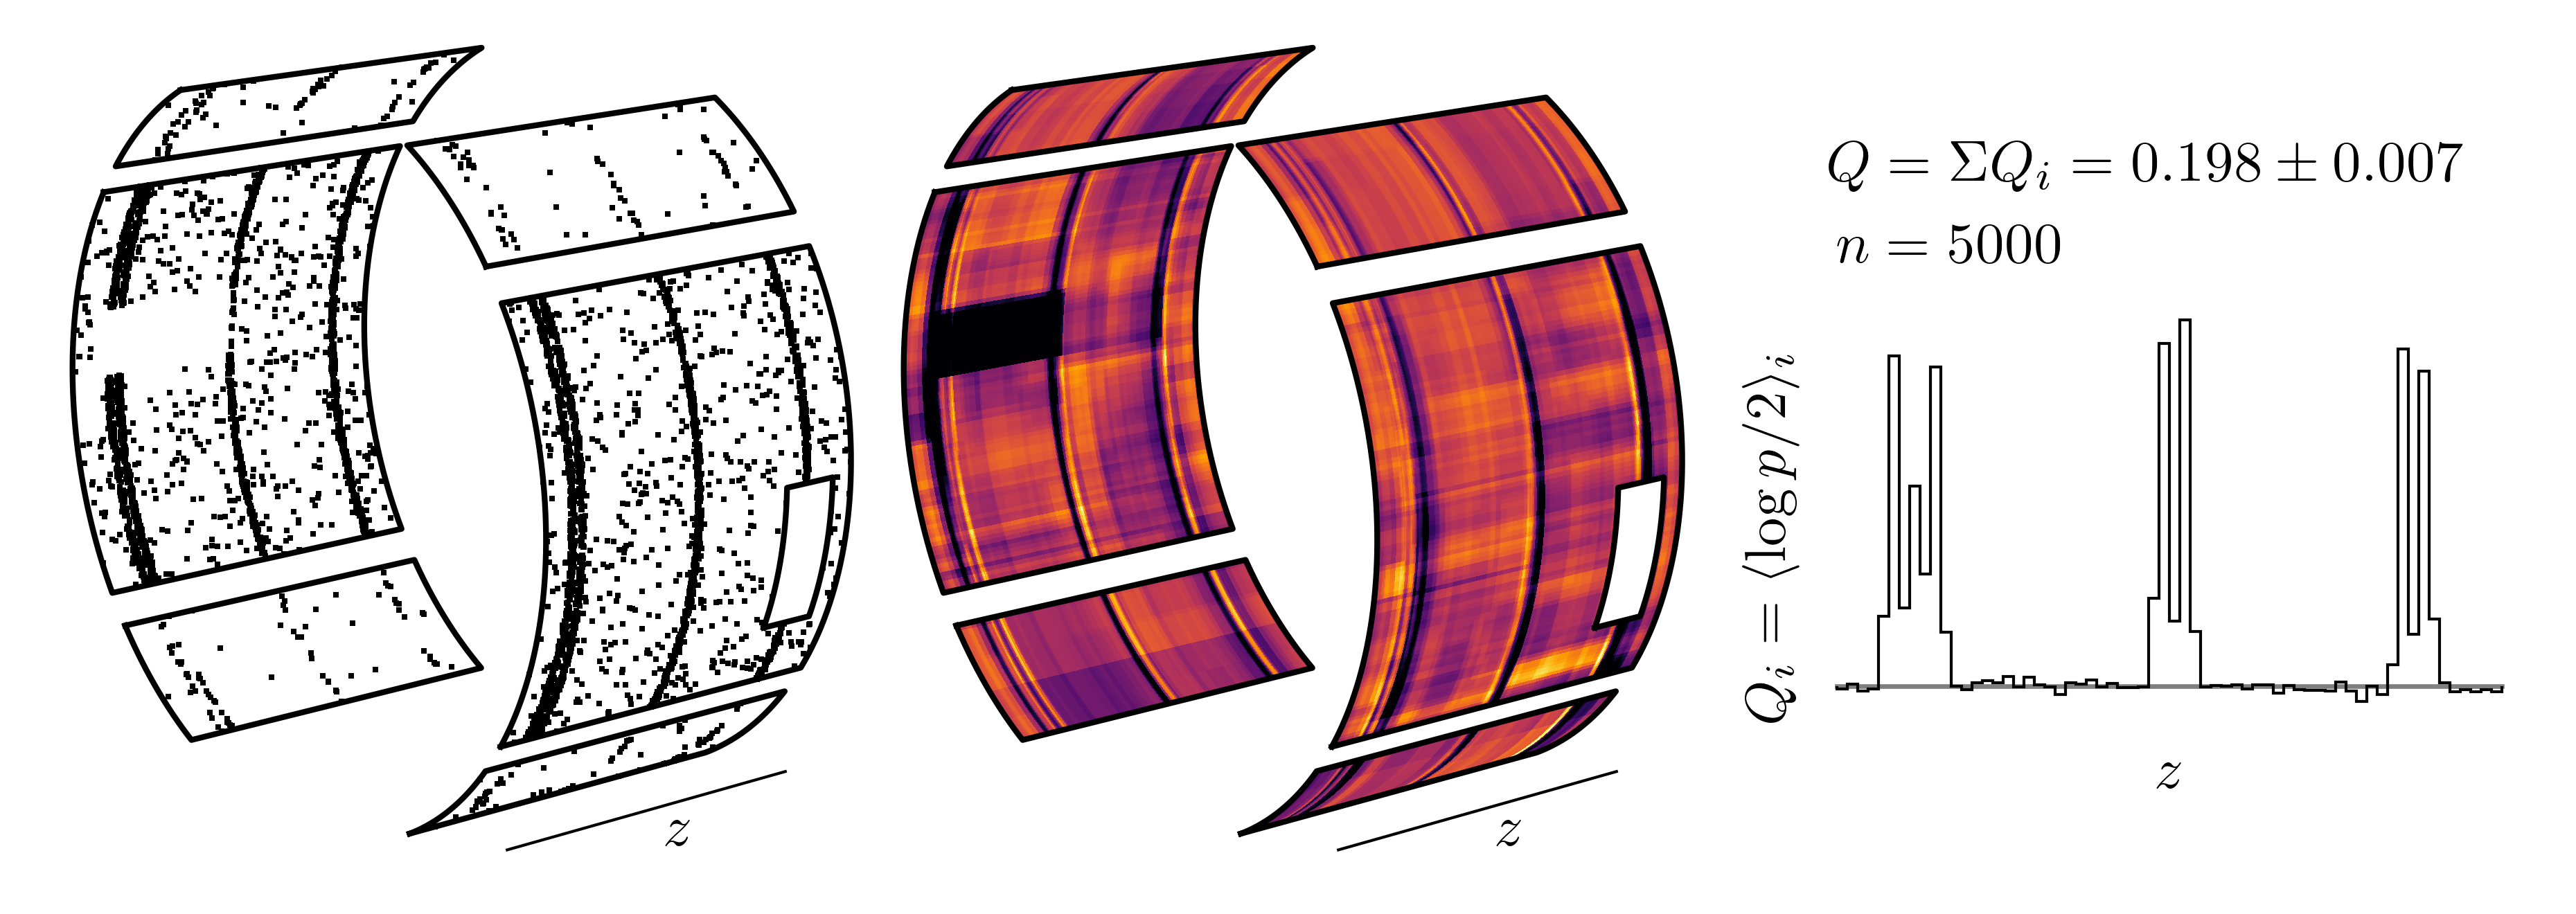

In [5]:
example_ring(
    "abstract",
    x_train,
    x_test,
    filter_,
)

# main: second example (fix that hole in the back)

suffix: fix_hole
mean llr: 0.180 +- 0.006


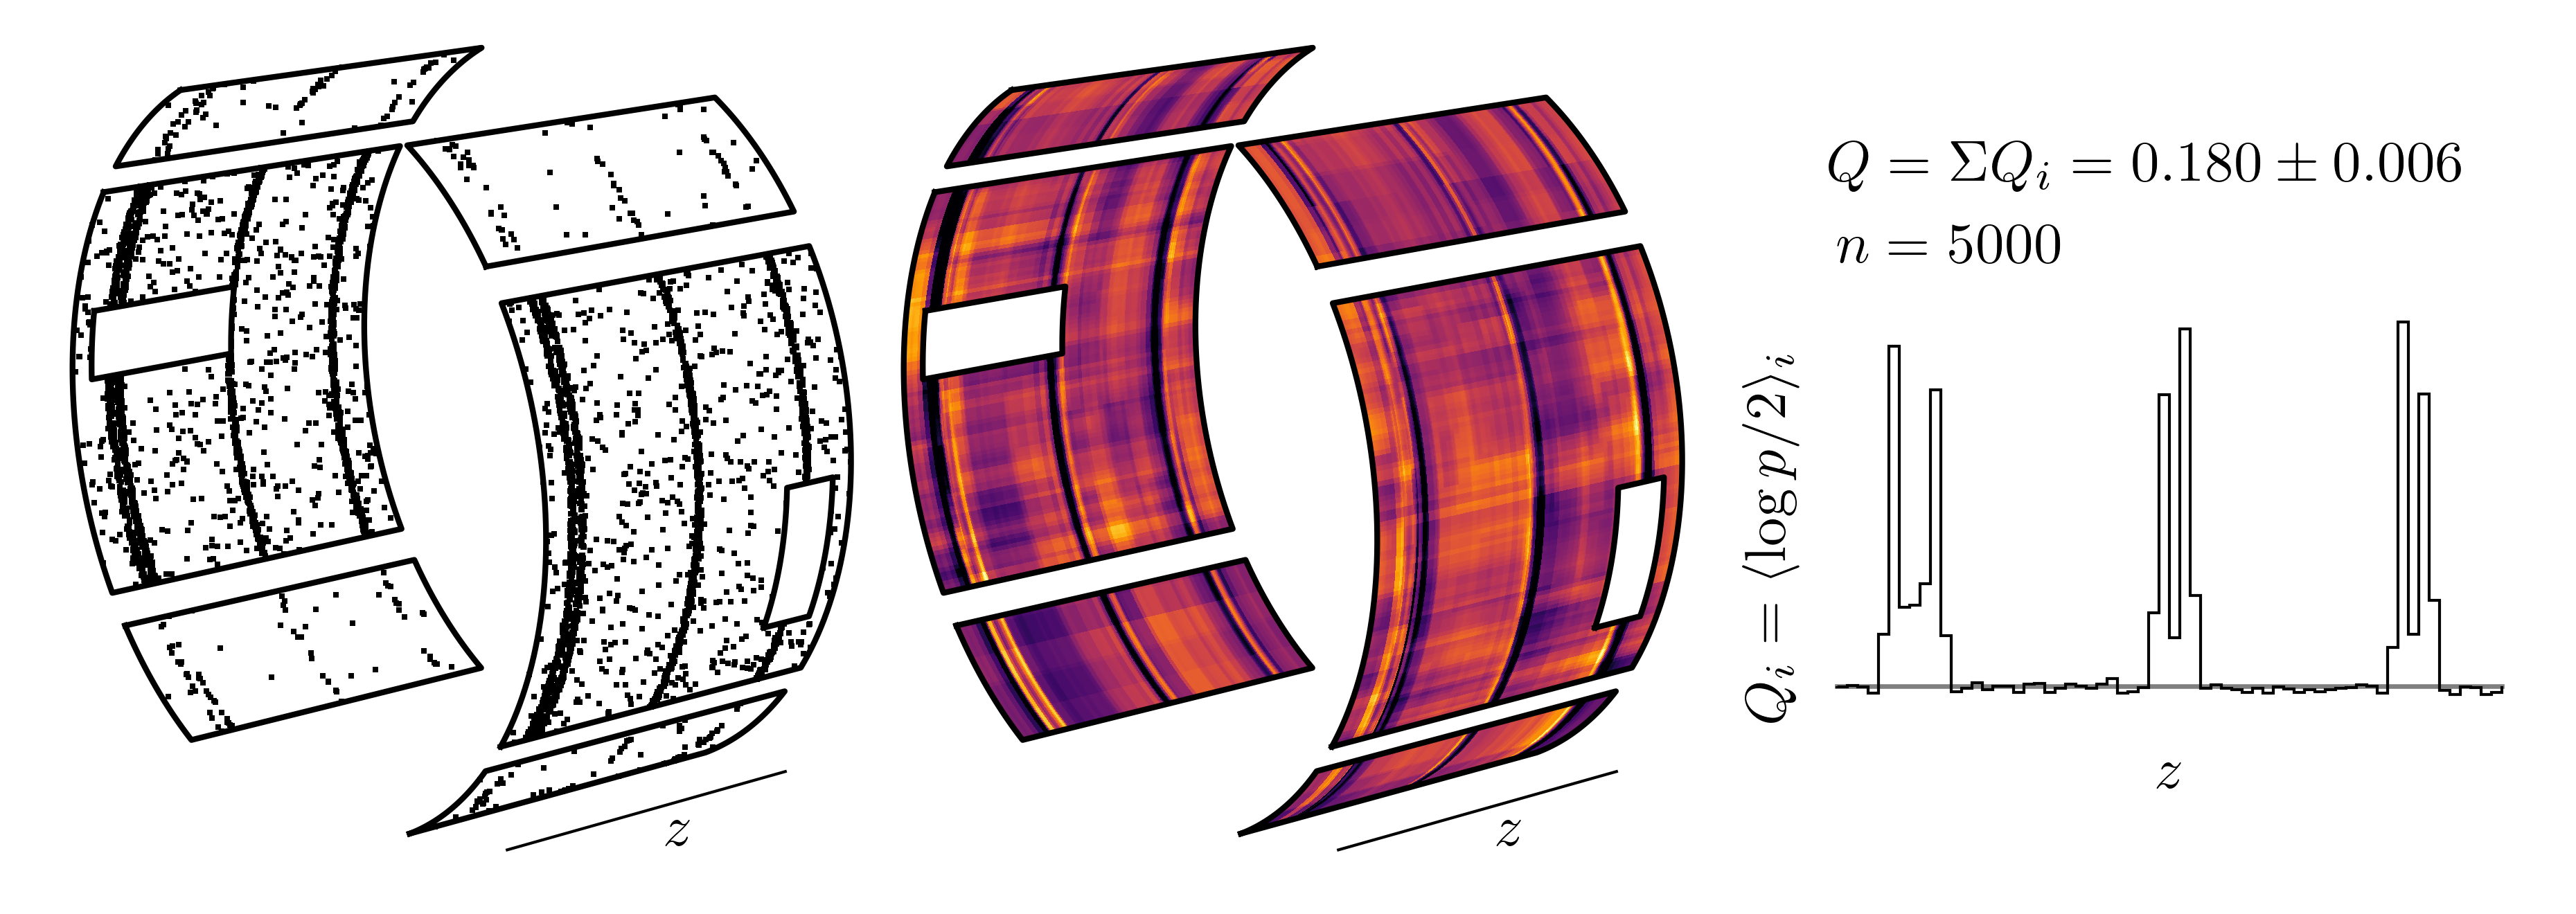

In [6]:
example_ring(
    "fix_hole",
    x_train,
    x_test,
    filter_true,
    draw_filters=FILTERS + [HOLE],
)

# main: third example (recalibrate the detector to align the rings)

In [7]:
# fix the offset and redo data
# (sorry for fiddling with globals)
data = map_sample(dist_no_wave * filter_true, ndata * 2)

x_train = data[:ndata]
x_test = data[ndata:]

suffix: no_wave
mean llr: -0.028 +- 0.004


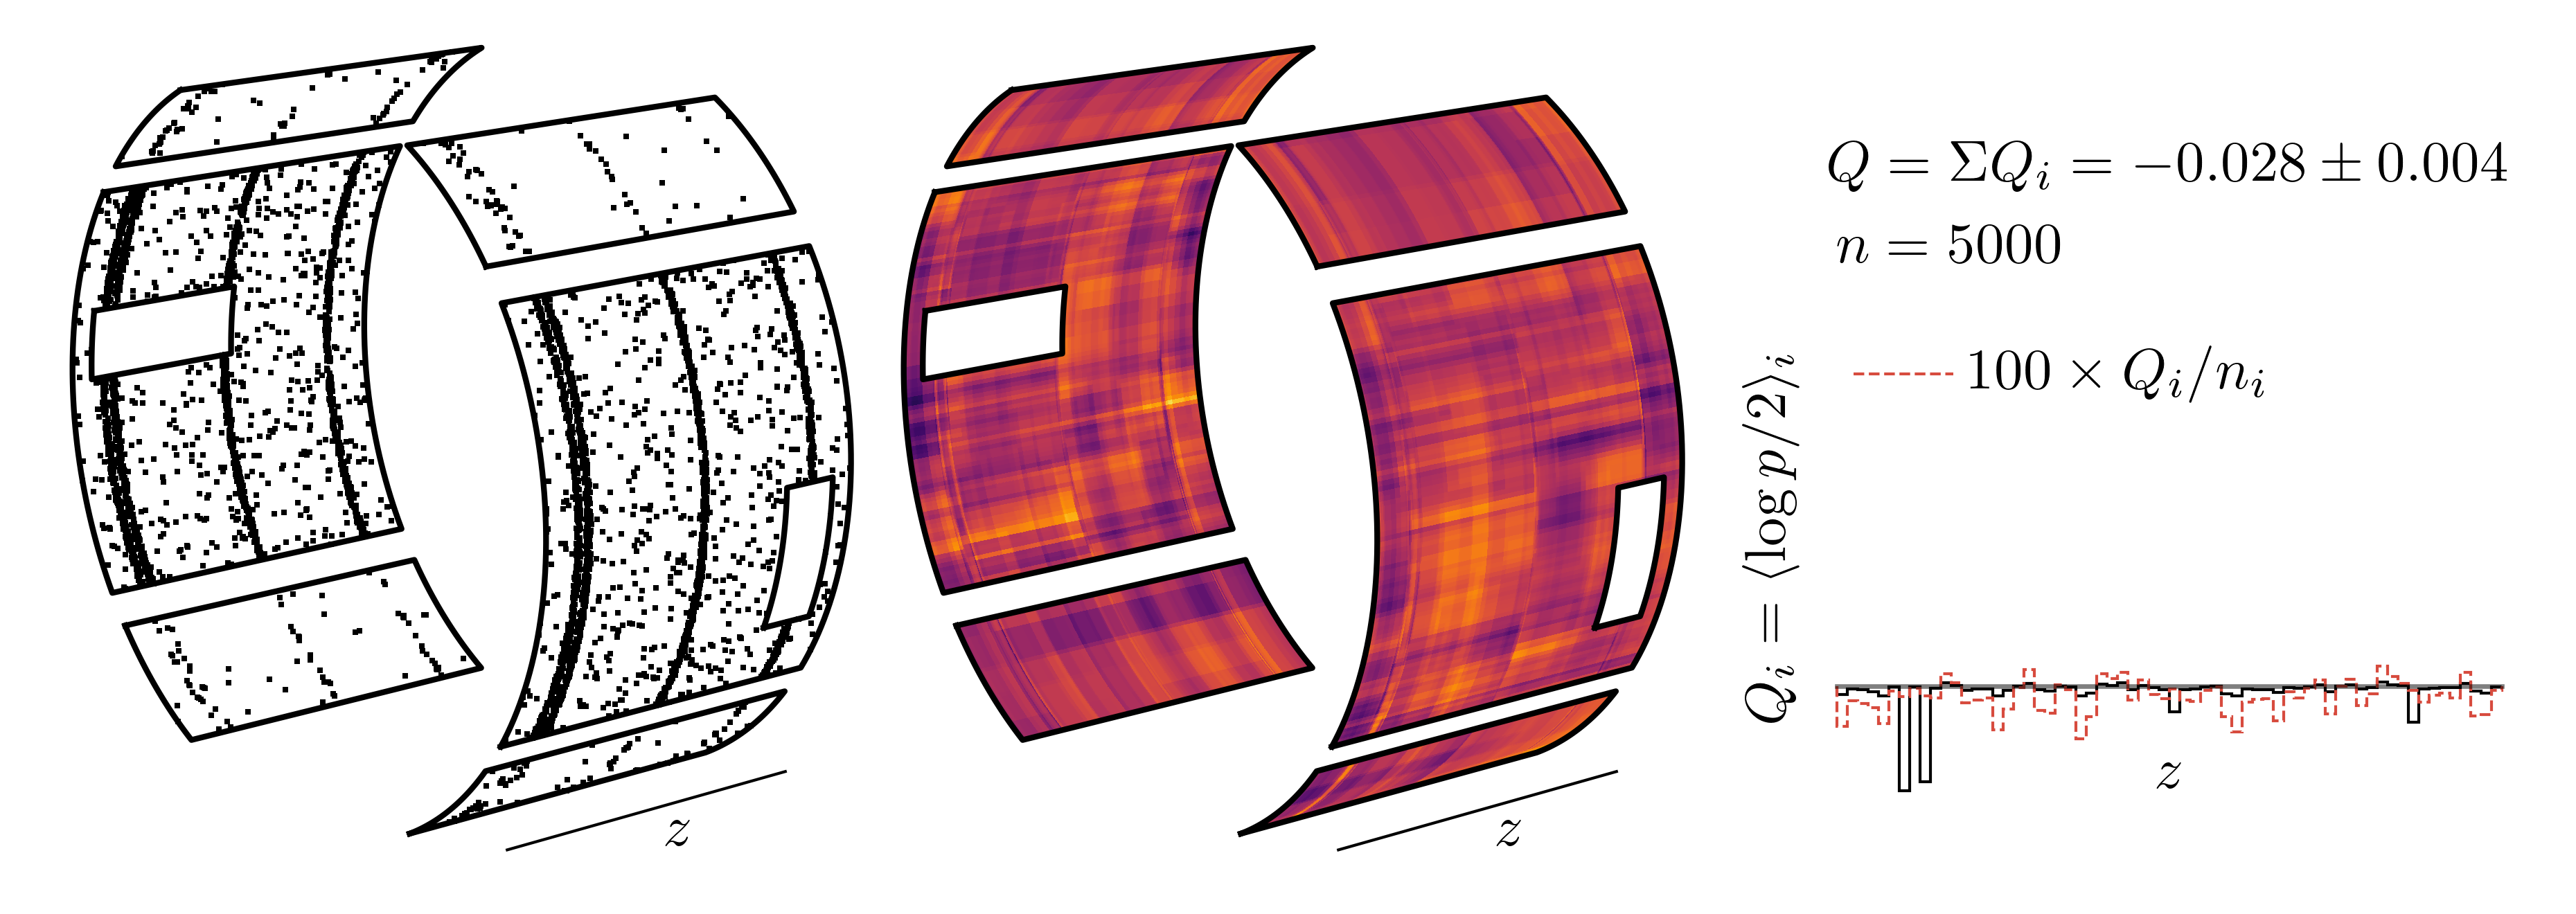

In [8]:
example_ring(
    "no_wave",
    x_train,
    x_test,
    filter_true,
    draw_filters=FILTERS + [HOLE],
    do_averages=True,
)